In [2]:
!pip install -q transformers
!pip install keras-tuner -q
!pip install visualkeras
!pip install pydot
!pip install graphviz



import re
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import sys
from google.colab import files
from transformers import TFBertModel, BertTokenizer, BertConfig
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from keras.optimizers import Adam
from keras import utils
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 21.5 MB/s eta 0:00:00


In [3]:
uploaded = files.upload()

Saving PAAC.txt to PAAC.txt
Saving TestSet.txt to TestSet.txt
Saving TrainSet.txt to TrainSet.txt


In [4]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [5]:
uploaded_fasta_train = list(uploaded.keys())[2]
fasta_content_train = uploaded[uploaded_fasta_train].decode('utf-8')  # Decode the bytes to a string
print(uploaded_fasta_train)
print(len(fasta_content_train))
#print(fasta_content_train)

uploaded_fasta_test = list(uploaded.keys())[1]
fasta_content_test = uploaded[uploaded_fasta_test].decode('utf-8')  # Decode the bytes to a string
print(uploaded_fasta_test)
print(len(fasta_content_test))
#print(fasta_content_test)

TrainSet.txt
24795
TestSet.txt
5994


## Data Preprocessing

In [6]:
#Reading Train Dataset with FASTA format
sequences_train = {}
current_header_train = None
current_sequence_train = []

#Parse train
for line in fasta_content_train.split('\n'):
    line = line.strip()
    if line.startswith(">"):  # Header line
        if current_header_train is not None:
            sequences_train[current_header_train] = ''.join(current_sequence_train)
        current_header_train = line[1:]  # Remove the '>' character
        current_sequence_train = []
    else:
        current_sequence_train.append(line)

#Don't forget to add the last sequence
if current_header_train is not None:
    sequences_train[current_header_train] = ''.join(current_sequence_train)

labels_train = []

for header in sequences_train.keys():
    if "Positive" in header:
        labels_train.append("Positive")
    elif "Negative" in header:
        labels_train.append("Negative")

y_train = [label == 'Positive' for label in labels_train]
print("Toplam pozitif train örnek sayısı:", sum(y_train))
print("Toplam negatif train örnek sayısı:", len(y_train) - sum(y_train))
print("length of y_train:", len(y_train))
#print(y_train)

#----------------------------------------
print("--------------------------")

#Reading Test Dataset with FASTA format
sequences_test = {}
current_header_test = None
current_sequence_test = []

# Parse the FASTA content test
for line in fasta_content_test.split('\n'):
    line = line.strip()
    if line.startswith(">"):  # Header line
        if current_header_test is not None:
            sequences_test[current_header_test] = ''.join(current_sequence_test)
        current_header_test = line[1:]  # Remove the '>' character
        current_sequence_test = []
    else:
        current_sequence_test.append(line)

# Don't forget to add the last sequence
if current_header_test is not None:
    sequences_test[current_header_test] = ''.join(current_sequence_test)

# pozitif veya negatif diye sırasıyla alan array
labels_test = []

for header in sequences_test.keys():
    if "Positive" in header:
        labels_test.append("Positive")
    elif "Negative" in header:
        labels_test.append("Negative")

print("Toplam pozitif train örnek sayısı:", sum(y_train))
print("Toplam negatif train örnek sayısı:", len(y_train) - sum(y_train))
y_test = [label == 'Positive' for label in labels_test]
print("length of the y_test: ", len(y_test))
#print(y_test)


Toplam pozitif train örnek sayısı: 474
Toplam negatif train örnek sayısı: 474
length of y_train: 948
--------------------------
Toplam pozitif train örnek sayısı: 474
Toplam negatif train örnek sayısı: 474
length of the y_test:  236


In [7]:
sequences_Example_train = []
length_train = []

for sequence in sequences_train.values():
    formatted_sequence = ' '.join(sequence)

    sequences_Example_train.append(formatted_sequence)
    length_train.append(len(sequence))

#print(length_train)
print("Min Train Sequence Length:", min(length_train))
print("Max Train Sequence Length:", max(length_train))
print("Train sequences:", sequences_Example_train)

sequences_Example_test = []
length_test = []

for sequence in sequences_test.values():
    formatted_sequence = ' '.join(sequence)
    sequences_Example_test.append(formatted_sequence)
    length_test.append(len(sequence))


#print(length_test)
print("Min Test Sequence Length:", min(length_test))
print("Max Test Sequence Length:",max(length_test))
print("Test sequences:", sequences_Example_test)

Min Train Sequence Length: 8
Max Train Sequence Length: 20
Train sequences: ['N Y D A N K T G L', 'L I Y D S S L C D L', 'L Y A W E P S F L', 'K M V E L V H F L', 'Y Q G S Y G F R L', 'K T V N E L Q N L', 'I Q N L E R G Y R', 'E V Y D G R E H S A', 'V M A G V G S P Y V', 'A Y R P V S R N I', 'A G Y L M E L C F', 'M V Y D L Y K T L', 'R L D F N L I R V', 'Y Y I M F G P D I', 'E S L F R A V I T K', 'S E I W R D I D F', 'A A G I G I L T V', 'I S G G P R I S Y', 'A L S V M G V Y V', 'Y L N T V Q P T C V', 'A E A L Q R P V', 'L V F G I E V V E V', 'E Y S K E C L K E F', 'D Y L R S V L E D F', 'A E P I N I Q T W', 'K F H R V I K D F', 'E A D P T G H S Y', 'T M N G S K S P V', 'M E V D P I G H L Y', 'L L D V A P L S L', 'E Y I L S L E E L', 'V L Y R Y G S F S V', 'F P S D S W C Y F', 'L L G P G R P Y R', 'E V D P I G H V Y', 'D Y V R E H K D N I', 'V G L I R N L A L', 'K T L T S V F Q K K', 'F L A L I I C N A', 'A L L M A G L A L', 'A L T P V V V T L', 'A G Y L M E L C M', 'A L I H H N T H L'

In [8]:
#Combining X and y by zipping them together
combined_data = list(zip(sequences_Example_train,y_train))
random.seed(42)
random.shuffle(combined_data)

#Seperate mixed X and y pairs
sequences_Example_train, y_train = zip(*combined_data)

print("Mixed X_train Sequences:", sequences_Example_train)
print("Mixed y_train Values:", y_train)


Mixed X_train Sequences: ('F L D E F M E G V', 'A Q Y Q F T G I K K Y', 'A I R Q Q I E S Y', 'R Q F S T P F Q L', 'F Q K V I T E Y', 'G V F G F P L G R', 'K M D A E H P E L', 'I T D K N S L A Y', 'D E A A I S K L Y', 'H S R N E G V A T Y', 'M L W G W R E H V', 'G Q K Q Y N V D Y', 'S L A D T N S L A V', 'F M V E L V E G A', 'G T L N Q P L T K', 'R I A E C I L G M', 'G L A S F K S F L K', 'T Y L P T N A S L', 'L L D G V V E K L', 'A Q Y E N P P H I Y', 'N V L H F F N A P L', 'E E F S R A A E K L Y', 'N Y N N F Y R F L', 'A E I D E E P V S K A', 'Y L D L F G D P S V', 'A F L P W H R L F L', 'F L Y T L L R E V', 'I L L W Q P I P V', 'I G K V V Q V Y', 'F I K D Y P V V S I', 'A Q K K P F T P V K Y', 'A L L D R I V S V', 'F V E T E S V R Y', 'F A K P F L A S L', 'G Q F S K P F S F', 'A Q N A V R L H Y', 'S L S K I L D T V', 'I Q R Q E T I S L', 'S Y L D S G I H F', 'D E I E N V A K Q F', 'Q Q L C V Y W T V', 'I L F S E G L I K A', 'A L S V M G V Y V', 'F L A L I I C N A', 'A E I D L F R A A

In [9]:
#Extracting feature embeddings for X_train
sequences_Example_train = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example_train]
ids_train = tokenizer.batch_encode_plus(sequences_Example_train, add_special_tokens=True, padding=True, return_tensors="tf")
input_ids = ids_train['input_ids']
attention_mask = ids_train['attention_mask']
embedding = model(input_ids)[0]
embedding = np.asarray(embedding)
attention_mask = np.asarray(attention_mask)
X_train = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][1:seq_len-1]
    X_train.append(seq_emd)


#print(X_train)
print("Length of X_train:", len(X_train))


sequences_Example_test = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example_test]
ids_test = tokenizer.batch_encode_plus(sequences_Example_test, add_special_tokens=True, padding=True, return_tensors="tf")

input_ids_test = ids_test['input_ids']
attention_mask_test = ids_test['attention_mask']
embedding_test = model(input_ids_test)[0]
embedding_test = np.asarray(embedding_test)
attention_mask_test = np.asarray(attention_mask_test)
X_test = []
for seq_num in range(len(embedding_test)):
    seq_len = (attention_mask_test[seq_num] == 1).sum()
    seq_emd = embedding_test[seq_num][1:seq_len-1]
    X_test.append(seq_emd)

#print(X_test)
print("Length of X_test:", len(X_test))




Length of X_train: 948
Length of X_test: 236


In [10]:
"""
with open("train_embeddings.txt", "w+") as train_embeddings:
  train_embeddings.write(repr(X_train))

with open("test_embeddings.txt", "w+") as test_embeddings:
  test_embeddings.write(repr(X_test))

files.download('train_embeddings.txt')
files.download('test_embeddings.txt')"""
print(type(X_train))

"""

np.save("train_embeddings.npy", X_train)
np.save("train_embeddings.npy", X_test)
files.download('train_embeddings.npy')
files.download('test_embeddings.npy')
"""

<class 'list'>


'\n\nnp.save("train_embeddings.npy", X_train)\nnp.save("train_embeddings.npy", X_test)\nfiles.download(\'train_embeddings.npy\')\nfiles.download(\'test_embeddings.npy\')\n'

In [11]:
#Adding new 1024 features by taking means and stdev for each sequence (1024 + 1024 = 2048 features for every sequence)

result_matrix_train = []
for i in range(len(X_train)):
    mean_matrix_train = np.mean(X_train[i], axis=0, keepdims=True)
    std_matrix_train = np.std(X_train[i], axis=0, keepdims=True)
    result_matrix_train.append(np.hstack((mean_matrix_train, std_matrix_train)) )

X_train_final = np.vstack(result_matrix_train)

print("Shape of new train features:", X_train_final.shape)


result_matrix_test = []
for i in range(len(X_test)):
    mean_matrix_test = np.mean(X_test[i], axis=0, keepdims=True)
    std_matrix_test = np.std(X_test[i], axis=0, keepdims=True)
    result_matrix_test.append(np.hstack((mean_matrix_test, std_matrix_test)) )

X_test_final = np.vstack(result_matrix_test)


print("Shape of new test features:", X_test_final.shape)



Shape of new train features: (948, 2048)
Shape of new test features: (236, 2048)


In [12]:
mean_matrix_train.shape

(1, 1024)

## iTTCA-RF (Chemical) Features Extraction

In [13]:
#ITTCA-RF- Feature extraction
#!/usr/bin/env python
#_*_coding:utf-8_*_

from collections import Counter
import numpy as np
import re
import math

sequences_Example_train = [sequence.replace(" ", "") for sequence in sequences_Example_train]
fastas_train = sequences_Example_train

sequences_Example_test = [sequence.replace(" ", "") for sequence in sequences_Example_test]
fastas_test = sequences_Example_test

def Count_1(seq1, seq2):
    sum = 0
    for aa in seq1:
        sum = sum + seq2.count(aa)
    return sum
def Count_2(aaSet, sequence):
    number = 0
    for aa in sequence:
        if aa in aaSet:
            number = number + 1
    cutoffNums = [1, math.floor(0.25 * number), math.floor(0.50 * number), math.floor(0.75 * number), number]
    cutoffNums = [i if i >=1 else 0 for i in cutoffNums]
    code = []
    for cutoff in cutoffNums:
        myCount = 0
        if cutoff == 0:
            code.append(0)
        else:
            for i in range(len(sequence)):
                if sequence[i] in aaSet:
                    myCount += 1
                    if myCount == cutoff:
                        code.append((i + 1) / len(sequence) * 100)
                        break
            if myCount == 0:
                code.append(0)
    return code

AA = 'ACDEFGHIKLMNPQRSTVWY'
group = {
        'alphaticr': 'GAVLMI',
        'aromatic': 'FYW',
        'postivecharger': 'KRH',
        'negativecharger': 'DE',
        'uncharger': 'STCPNQ'}

group1 = {
        'hydrophobicity': 'RKEDQN',  # 疏水性特征
        'normwaalsvolume': 'GASCTPD',  # 范德华力
        'polarity': 'LIFWCMVY',  # 极性
        'polarizability': 'GASDT',  # 极化性质
        'charge': 'KR',  # 电荷性质
        'surfacetension': 'GQDNAHR',  # 表面张力
        'secondarystruct': 'EALMQKRH',  # 二级结构
        'solventaccess': 'ALFCGIVW'}  # 溶剂可及性

group2 = {
        'hydrophobicity': 'GASTPHY',
        'normwaalsvolume': 'NVEQIL',
        'polarity': 'PATGS',
        'polarizability': 'CPNVEQIL',
        'charge': 'ANCQGHILMFPSTWYV',
        'surfacetension': 'KTSEC',
        'secondarystruct': 'VIYCWFT',
        'solventaccess': 'RKQEND'}
group3 = {
        'hydrophobicity': 'CVLIMFW',
        'normwaalsvolume': 'MHKFRYW',
        'polarity': 'HQRKNED',
        'polarizability': 'KMHFRYW',
        'charge': 'DE',
        'surfacetension': 'ILMFPWYV',
        'secondarystruct': 'GNPSD',
        'solventaccess': 'MPSTHY'}
property = ('hydrophobicity', 'normwaalsvolume',
                'polarity', 'polarizability', 'charge', 'surfacetension', 'secondarystruct', 'solventaccess')

def get_features(fastas):
    def AAC():
        encoding = []
        for sequence in fastas:
            count = Counter(sequence)
            for key in count:
                count[key] = count[key]/len(sequence) * 100
            code = []
            for aa in AA:
                code.append(count[aa])
            encoding.append(code)
        return encoding

    def CTDC(p):
        encodings = []
        for sequence in fastas:
            code = []
            c1 = Count_1(group1[p], sequence)/len(sequence)*100
            c2 = Count_1(group2[p], sequence)/len(sequence)*100
            c3 = 100 - c1 - c2
            code = code + [c1, c2, c3]
            encodings.append(code)
        return encodings


    def CTDT(p):
        encodings = []
        for sequence in fastas:
            code = []
            aaPair = [sequence[j:j + 2] for j in range(len(sequence) - 1)]
            if not aaPair:
              code = [0,0,0]
            else:
              c1221, c1331, c2332 = 0, 0, 0
              for pair in aaPair:
                  if (pair[0] in group1[p] and pair[1] in group2[p]) or (
                          pair[0] in group2[p] and pair[1] in group1[p]):
                      c1221 = c1221 + 1
                      continue
                  if (pair[0] in group1[p] and pair[1] in group3[p]) or (
                          pair[0] in group3[p] and pair[1] in group1[p]):
                      c1331 = c1331 + 1
                      continue
                  if (pair[0] in group2[p] and pair[1] in group3[p]) or (
                          pair[0] in group3[p] and pair[1] in group2[p]):
                      c2332 = c2332 + 1
              code = code + [c1221/len(aaPair)*100, c1331/len(aaPair)*100, c2332/len(aaPair)*100]
            encodings.append(code)
        return encodings

    def CTDD(p):
        encodings = []
        for sequence in fastas:
            code = []
            code = code + Count_2(group1[p], sequence) + Count_2(group2[p], sequence) + Count_2(group3[p], sequence)
            encodings.append(code)
        return encodings

    def GAAC():
        encoding = []
        groupKey = group.keys()
        for sequence in fastas:
            code = []
            count = Counter(sequence)
            myDict = {}
            for key in groupKey:
                for aa in group[key]:
                    myDict[key] = myDict.get(key, 0) + count[aa]
            for key in groupKey:
                code.append(myDict[key] / len(sequence))
            encoding.append(code)
        return encoding

    def GDPC():
        groupKey = group.keys()
        #baseNum = len(groupKey)
        dipeptide = [g1 + '.' + g2 for g1 in groupKey for g2 in groupKey]
        index = {}
        for key in groupKey:
            for aa in group[key]:
                index[aa] = key
        encodings = []
        for sequence in fastas:
            code = []
            myDict = {}
            for t in dipeptide:
                myDict[t] = 0

            sum = 0
            for j in range(len(sequence) - 2 + 1):
                myDict[index[sequence[j]] + '.' + index[sequence[j + 1]]] = myDict[index[sequence[j]] + '.' + index[
                    sequence[j + 1]]] + 1
                sum = sum + 1

            if sum == 0:
                for t in dipeptide:
                    code.append(0)
            else:
                for t in dipeptide:
                    code.append(myDict[t] / sum)
            encodings.append(code)
        return encodings

    def GTPC():
        groupKey = group.keys()
        baseNum = len(groupKey)
        triple = [g1 + '.' + g2 + '.' + g3 for g1 in groupKey for g2 in groupKey for g3 in groupKey]
        index = {}
        for key in groupKey:
            for aa in group[key]:
                index[aa] = key
        encodings = []

        for sequence in fastas:
            code = []
            myDict = {}
            for t in triple:
                myDict[t] = 0

            sum = 0
            for j in range(len(sequence) - 3 + 1):
                myDict[index[sequence[j]] + '.' + index[sequence[j + 1]] + '.' + index[sequence[j + 2]]] = myDict[index[sequence[j]] + '.' +index[sequence[j + 1]] + '.' +index[sequence[j + 2]]] + 1
                sum = sum + 1
            if sum == 0:
                for t in triple:
                    code.append(0)
            else:
                for t in triple:
                    code.append(myDict[t] / sum)
            encodings.append(code)
        return encodings

    def Rvalue(aa1, aa2, AADict, Matrix):
        return sum([(Matrix[i][AADict[aa1]] - Matrix[i][AADict[aa2]]) ** 2 for i in range(len(Matrix))]) / len(Matrix)


    def PAAC():
        dataFile = '/content/PAAC.txt' #r'PAAC.TXT'
        with open(dataFile) as f:
            records = f.readlines()
        AA = ''.join(records[0].rstrip().split()[1:])
        # AA = "ARNDCQEGHILKMFPSTWYV"
        AADict = {}
        for i in range(len(AA)):  # 20
            AADict[AA[i]] = i
        AAProperty = []
        AAPropertyNames = []
        for i in range(1, len(records)):  # llen(records) 4
            array = records[i].rstrip().split() if records[i].rstrip() != '' else None
            AAProperty.append([float(j) for j in array[1:]])
            AAPropertyNames.append(array[0])

        AAProperty1 = []
        for i in AAProperty:
            meanI = sum(i) / 20
            fenmu = math.sqrt(sum([(j - meanI) ** 2 for j in i]) / 20)
            AAProperty1.append([(j - meanI) / fenmu for j in i])

        encodings = []

        for sequence in fastas:
            code = []
            theta = []
            for n in range(1, min(3, len(sequence))):
            #for n in range(1, 3):
                theta.append(
                    sum([Rvalue(sequence[j], sequence[j + n], AADict, AAProperty1) for j in
                         range(len(sequence) - n)]) / (
                            len(sequence) - n))
            myDict = {}
            for aa in AA:
                myDict[aa] = sequence.count(aa)
            code = code + [myDict[aa] / (1 + 0.05 * sum(theta)) for aa in AA]
            code = code + [(0.05 * j) / (1 + 0.05 * sum(theta)) for j in theta]
            encodings.append(code)
        return encodings

    print('Feature extraction...')
    encoding = []
    encoding.append(AAC())
    for p in property:
        encoding.append(CTDC(p))
        encoding.append(CTDT(p))
        encoding.append(CTDD(p))
    encoding.append(GAAC())
    encoding.append(GDPC())
    encoding.append(GTPC())
    encoding.append(PAAC())
    return np.column_stack(encoding)

ittca_features_train = get_features(fastas_train)
ittca_features_test = get_features(fastas_test)

print("There are 365 features for every sequence as you see below:")
print("Shape of chemical features in train set:", ittca_features_train.shape)
print("Shape of chemical features in test set:", ittca_features_test.shape)



Feature extraction...
Feature extraction...
There are 365 features for every sequence as you see below:
Shape of chemical features in train set: (948, 365)
Shape of chemical features in test set: (236, 365)


In [14]:
# 1024 train feature ı 3d array yapma
X_train_expanded = []

for matrix in X_train:

    new_matrix = np.zeros((50, 1024))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    X_train_expanded.append(new_matrix)



X_train_expanded_3d = np.stack(X_train_expanded, axis = 0)
print(X_train_expanded_3d.shape)

X_train_expanded_11 = []

for matrix in X_train_expanded_3d:
    new_matrix = matrix[:11, :]   # Her bir matrisin ilk 1024 sütununu seç
    X_train_expanded_11.append(new_matrix)

X_train_expanded_11 = np.stack(X_train_expanded_11, axis=0)
print(X_train_expanded_11.shape)

#1024 test feature ı 3d array yapma
X_test_expanded = []

for matrix in X_test:
    new_matrix = np.zeros((50, 1024))
    new_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    X_test_expanded.append(new_matrix)

X_test_expanded_3d = np.stack(X_test_expanded, axis = 0)
print(X_test_expanded_3d.shape)


X_test_expanded_11 = []

for matrix in X_test_expanded_3d:
    new_matrix = matrix[:11, :]   # Her bir matrisin ilk 1024 sütununu seç
    X_test_expanded_11.append(new_matrix)

X_test_expanded_11 = np.stack(X_test_expanded_11, axis=0)
print(X_test_expanded_11.shape)

#print(X_train_expanded_11)


(948, 50, 1024)
(948, 11, 1024)
(236, 50, 1024)
(236, 11, 1024)


### Data Scaling

In [15]:
#Data Scaling
#3d data için scaling yapıldı ama kullanmıyoruz onu sadece ittca rf nin scaling ini kullanıcaz
from sklearn.preprocessing import StandardScaler

print("Before")
print("Min of chemical train features Before Scaling:", ittca_features_train.min())
print("Max of chemical train features Before Scaling:", ittca_features_train.max())
print("Min of chemical test features Before Scaling:", ittca_features_test.min())
print("Max of chemical test features Before Scaling:", ittca_features_test.max())

scaler = StandardScaler()
ittca_features_train_scaled = scaler.fit_transform(ittca_features_train)
ittca_features_test_scaled = scaler.fit_transform(ittca_features_test)

print("After")
print("Min of chemical train features After Scaling:", ittca_features_train_scaled.min())
print("Max of chemical train features After Scaling:", ittca_features_train_scaled.max())
print("Min of chemical test features After Scaling:", ittca_features_test_scaled.min())
print("Max of chemical test features After Scaling:", ittca_features_test_scaled.max())



Before
Min of chemical train features Before Scaling: -1.4210854715202004e-14
Max of chemical train features Before Scaling: 100.0
Min of chemical test features Before Scaling: -1.4210854715202004e-14
Max of chemical test features Before Scaling: 100.0
After
Min of chemical train features After Scaling: -12.463069919702553
Max of chemical train features After Scaling: 26.91490532044509
Min of chemical test features After Scaling: -6.498004686762923
Max of chemical test features After Scaling: 15.329709716755884


In [16]:

#kendi featurelarımız + stdev ler 2048 feature , random forest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(max_depth = 15, min_samples_split = 3, n_estimators = 150)
rf_classifier.fit(X_train_final, y_train)
y_pred = rf_classifier.predict(X_test_final)



accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

#kendi featurelarımız + stdev ler 2048 feature , random forest without hyperparameter tuned


Accuracy: 0.7627118644067796
Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.80      0.77       118
        True       0.78      0.73      0.75       118

    accuracy                           0.76       236
   macro avg       0.76      0.76      0.76       236
weighted avg       0.76      0.76      0.76       236



In [17]:
"""
#kendi featurelarımız + stdev ler 2048 features , xgboost
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

xgb_classifier = XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 200, random_state=0)
xgb_classifier.fit(X_train_final, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_final)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Classification Report:\n", classification_rep_xgb)
"""


'\n#kendi featurelarımız + stdev ler 2048 features , xgboost\nfrom xgboost import XGBClassifier\nimport numpy as np\nfrom sklearn.metrics import accuracy_score, classification_report\n\nxgb_classifier = XGBClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 200, random_state=0)\nxgb_classifier.fit(X_train_final, y_train)\ny_pred_xgb = xgb_classifier.predict(X_test_final)\n\naccuracy_xgb = accuracy_score(y_test, y_pred_xgb)\nclassification_rep_xgb = classification_report(y_test, y_pred_xgb)\n\nprint("XGBoost Accuracy:", accuracy_xgb)\nprint("XGBoost Classification Report:\n", classification_rep_xgb)\n'

## DeepT-i (Inception Module Based 2D CNN with deep features from ProtBERT)

In [18]:
#0.8729 accuracy

def create_inception_11(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)
    # MaxPooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])
    return out

def inception_11(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11(input_layer)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)  # Assuming binary classification
    model = Model(inputs=input_layer, outputs=x)
    return model

# Define model
input_shape = (11, 1024, 1)  # Example input shape
model = inception_11(input_shape)
model.summary()



adam_optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01, verbose=1)


y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

history_11 = model.fit(X_train_expanded_11, y_train_categorical, epochs=95, batch_size=948, validation_split=0.1)
model.evaluate(X_test_expanded_11, y_test_categorical)

y_prob11 = model.predict(X_test_expanded_11)

fpr1, tpr1, thresholds = roc_curve(y_test, y_prob11[:, 1])
auc1 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc1)

from sklearn.metrics import classification_report

# Predict class labels on the test set
y_pred = model.predict(X_test_expanded_11)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Ensure y_test is in the correct format, i.e., it should be a single column of labels, not one-hot encoded
if y_test_categorical.shape[1] > 1:
    y_test_classes = np.argmax(y_test_categorical, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already in the form of class labels

# Print the classification report
report = classification_report(y_test_classes, y_pred_classes)
print(report)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 1024, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 11, 1024, 32)         64        ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 11, 1024, 16)         4624      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 11, 1024, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## DeepT-Hybrid (Inception Module Based 2D CNN with hybrid features)

In [20]:
def create_inception_11_final(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)
    # MaxPooling
    pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])  # Fixed this
    return out

def inception_11_final(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11_final(input_layer)
    cnn_out = Flatten()(x)
   # cnn_out = Dropout(0.2)(x)

    extra_features_input = Input(shape=(365,))

    combined = Concatenate()([cnn_out, extra_features_input])
    combined_out = Dense(64, activation='relu')(combined)
    final_output = Dense(2, activation='softmax')(combined_out)  # Use softmax for binary classification

    my_adam = Adam(learning_rate=0.00005)
    model = Model(inputs=[input_layer, extra_features_input], outputs=final_output)
    model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define model
input_shape = (11, 1024, 1)  # Example input shape
model = inception_11_final(input_shape)
model.summary()

y_train_categorical = to_categorical(y_train, num_classes=2)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.01, verbose=1)

history_11_final = model.fit([X_train_expanded_11, ittca_features_train_scaled], y_train_categorical, epochs=60, batch_size=948, validation_split=0.1)

y_test_categorical = to_categorical(y_test, num_classes=2)
model.evaluate([X_test_expanded_11, ittca_features_test_scaled], y_test_categorical)

y_prob11_final = model.predict([X_test_expanded_11, ittca_features_test_scaled])

fpr2, tpr2, thresholds = roc_curve(y_test, y_prob11_final[:, 1])
auc2 = roc_auc_score(y_test, y_prob11_final[:, 1])
print('AUC: %0.2f' % auc2)


from sklearn.metrics import classification_report

# Predict class labels on the test set
y_pred_final = model.predict([X_test_expanded_11, ittca_features_test_scaled])
y_pred_final_classes = np.argmax(y_pred_final, axis=1)  # Convert probabilities to class labels

# Ensure y_test is in the correct format, i.e., it should be a single column of labels, not one-hot encoded
if y_test_categorical.shape[1] > 1:
    y_test_classes = np.argmax(y_test_categorical, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already in the form of class labels

# Print the classification report
report_final = classification_report(y_test_classes, y_pred_final_classes)
print(report_final)

model.save('model.h5')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 11, 1024, 1)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 11, 1024, 32)         64        ['input_2[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 11, 1024, 16)         4624      ['conv2d_2[0][0]']            
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 11, 1024, 16)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from keras.models import load_model

# Modeli dosyadan yükleyin
model = load_model('model.h5')

def visualize_model_networkx(model):
    G = nx.DiGraph()
    for layer in model.layers:
        G.add_node(layer.name)
        # Katmanın inbound_nodes özelliğini kontrol edin
        for node in layer._inbound_nodes:
            # inbound_layers tek bir katman veya bir liste olabilir
            inbound_layers = node.inbound_layers
            if isinstance(inbound_layers, list):
                # Eğer liste ise, listedeki her katman için kenar ekleyin
                for inbound_layer in inbound_layers:
                    if inbound_layer is not None:
                        G.add_edge(inbound_layer.name, layer.name)
            else:
                # Liste değilse, doğrudan bir kenar ekleyin
                if inbound_layers is not None:
                    G.add_edge(inbound_layers.name, layer.name)

    # Grafiği çizdir
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500, edge_color='k', linewidths=1, font_size=10)
    plt.show()

# Modelin NetworkX ile görsel temsilini çizdirin
visualize_model_networkx(model)


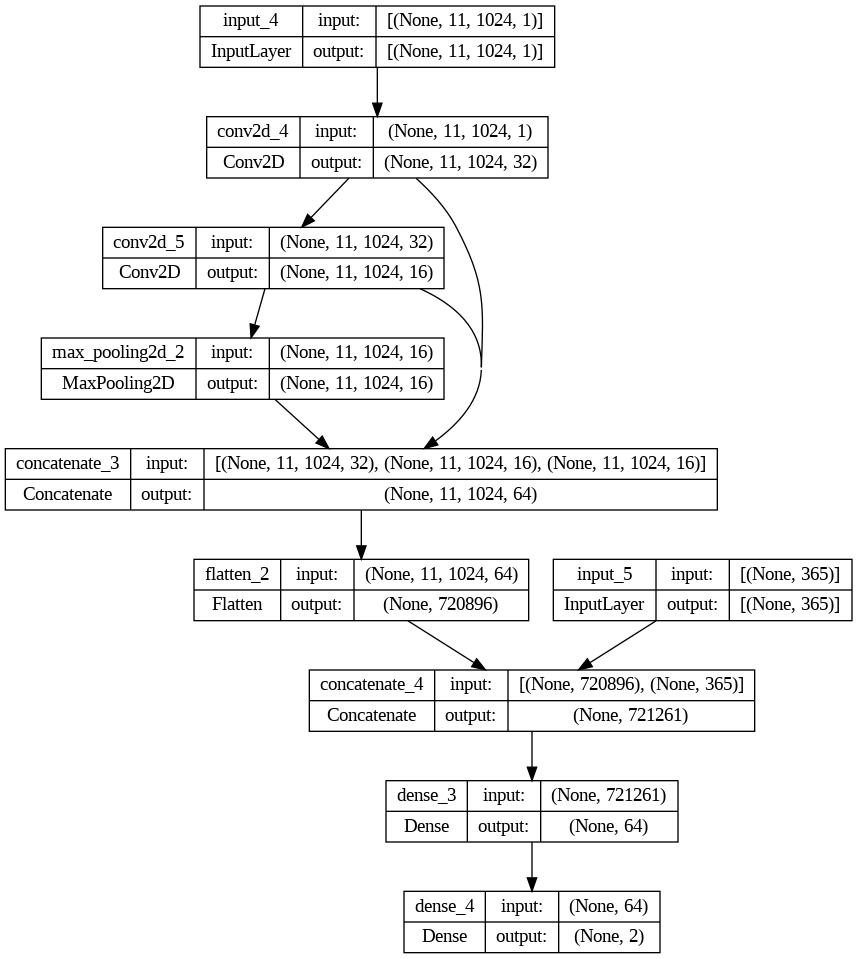

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image


def create_inception_11_final(input_layer):
    # 1x1 conv
    conv1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_layer)
    # 3x3 conv
    conv3 = Conv2D(16, (3,3), padding='same', activation='relu')(conv1)


    # MaxPooling
    pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(conv3)
    # Concatenate filters
    out = Concatenate()([conv1, conv3, pool])
    return out

def inception_11_final(input_shape):
    input_layer = Input(shape=input_shape)
    x = create_inception_11_final(input_layer)
    cnn_out = Flatten()(x)

    extra_features_input = Input(shape=(365,))

    combined = Concatenate()([cnn_out, extra_features_input])
    combined_out = Dense(64, activation='relu')(combined)
    final_output = Dense(2, activation='softmax')(combined_out)

    my_adam = Adam(learning_rate=0.00005)
    model = Model(inputs=[input_layer, extra_features_input], outputs=final_output)
    model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define model
input_shape = (11, 1024, 1)
model = inception_11_final(input_shape)

# Plot the model and save to file
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

# Display the model diagram
Image('model_diagram.png')


##iTTCA-RF (Random forest with chemical features)

In [27]:
#ittca features random forest
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(max_depth= 20, min_samples_leaf= 1, min_samples_split= 3, n_estimators= 200, random_state=0)
rf_classifier.fit(ittca_features_train, y_train)
y_pred = rf_classifier.predict(ittca_features_test)
y_prob = rf_classifier.predict_proba(ittca_features_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)



fpr3, tpr3, thresholds = roc_curve(y_test, y_prob)
auc3 = roc_auc_score(y_test, y_prob)
print('AUC: %0.2f' % auc3)


Accuracy: 0.864406779661017
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.84      0.86       118
        True       0.85      0.89      0.87       118

    accuracy                           0.86       236
   macro avg       0.87      0.86      0.86       236
weighted avg       0.87      0.86      0.86       236

AUC: 0.94


#Scaled Chemical Features Random Forest

In [ ]:
"""
#ittca features random forest with scaled features kullanılmayacak
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(ittca_features_train_scaled, y_train)
y_pred = rf_classifier.predict(ittca_features_test_scaled)



accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

fpr4, tpr4, thresholds = roc_curve(y_test, y_pred[:, 1])
auc4 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc4)
"""

###X_flatten

In [22]:

lengths_train = [len(seq) for seq in X_train]


max_length_train = max(lengths_train)


lengths_test = [len(seq) for seq in X_test]


max_length_test = max(lengths_test)


max_length = max(max_length_train, max_length_test)

def pad_and_flatten(sequences, max_length):
    padded_sequences = []
    for seq in sequences:
        # Diziyi padding ile doldur
        padding_length = max_length - len(seq)
        # Sıfır vektörlerle doldur
        padded_seq = np.concatenate([seq, np.zeros((padding_length, seq.shape[1]))], axis=0)
        # Düzleştirilmiş hali
        flattened_seq = padded_seq.flatten()
        padded_sequences.append(flattened_seq)
    return np.array(padded_sequences)

X_train_flat = pad_and_flatten(X_train, max_length)
X_test_flat = pad_and_flatten(X_test, max_length)

print(len(X_train))
print(X_train_flat.shape)


948
(948, 20480)


# RF + DeepFeatures Stdevs

In [ ]:
#ProtBERT features + stdevs -> 2048 feature , random forest hyperparameter tuned
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

param_grid = {
    'n_estimators': [150],
    'max_depth': [10],
    'min_samples_split': [3]
}
"""
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}"""

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

print("Best Params: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_
y_pred1 = best_rf_model.predict(X_test_final)
y_prob1 = best_rf_model.predict_proba(X_test_final)[:, 1]
classification_rep = classification_report(y_test, y_pred1)
print(classification_rep)

fpr6, tpr6, thresholds = roc_curve(y_test, y_prob1)
auc6 = roc_auc_score(y_test, y_prob1)
print('AUC: %0.2f' % auc6)
#kendi featurelarımız + stdev ler 2048 feature , random forest hyperparameter tuned

In [ ]:
"""
#ittca random forest hyperparameter tuned
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}


rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(ittca_features_train_scaled, y_train)

print("En iyi parametreler: ", grid_search.best_params_)
#print("En iyi doğruluk skoru: ", grid_search.best_score_)


# En iyi modeli alın
best_rf_model = grid_search.best_estimator_



y_pred = best_rf_model.predict(ittca_features_test_scaled)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

fpr7, tpr7, thresholds = roc_curve(y_test, y_prob11[:, 1])
auc7 = roc_auc_score(y_test, y_prob11[:, 1])
print('AUC: %0.2f' % auc7)
#ittca random forest hyperparameter tuned
"""

In [ ]:
"""
#ittca xgboost hyperparameter tuned
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.7, 1.0]
}


xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search.fit(ittca_features_train, y_train)

print("En iyi parametreler: ", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(ittca_features_test)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)

"""

## DeepT-RF (Random Forest with deep features from ProtBERT)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_classifier = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=3,
    random_state=56
)


rf_classifier.fit(X_train_flat, y_train)

y_pred = rf_classifier.predict(X_test_flat)
y_prob_rf = rf_classifier.predict_proba(X_test_flat)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print("Güncellenmiş Random Forest sınıflandırıcısının doğruluğu:", accuracy)


print(classification_report(y_test, y_pred))

fpr5, tpr5, thresholds = roc_curve(y_test, y_prob_rf)
auc5 = roc_auc_score(y_test, y_prob_rf)
print('AUC: %0.2f' % auc5)


Güncellenmiş Random Forest sınıflandırıcısının doğruluğu: 0.864406779661017
              precision    recall  f1-score   support

       False       0.90      0.82      0.86       118
        True       0.84      0.91      0.87       118

    accuracy                           0.86       236
   macro avg       0.87      0.86      0.86       236
weighted avg       0.87      0.86      0.86       236

AUC: 0.94


In [ ]:
"""
#ProtBERT features + stdevs -> 2048 feature , xgboost hyperparameter tuned
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 150],
    'max_depth': [3, 6]
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 6, 9],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train)

print("En iyi parametreler: ", grid_search.best_params_)


best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test_final)
classification_rep = classification_report(y_test, y_pred)

print(classification_rep)
"""

## DeepT-XGB (XGBoost with deep features from ProtBERT)

In [25]:
import xgboost as xgb


xgb_classifier = xgb.XGBClassifier(random_state=42, learning_rate = 0.2, n_estimators = 150, max_depth = 9 )

xgb_classifier.fit(X_train_flat, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_flat)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost sınıflandırıcısının doğruluğu:", accuracy_xgb)
y_prob_xgb = xgb_classifier.predict_proba(X_test_flat)[:, 1]

print(classification_report(y_test, y_pred_xgb))

fpr8, tpr8, thresholds = roc_curve(y_test, y_prob_xgb)
auc8 = roc_auc_score(y_test, y_prob_xgb)
print('AUC: %0.2f' % auc8)


XGBoost sınıflandırıcısının doğruluğu: 0.8686440677966102
              precision    recall  f1-score   support

       False       0.86      0.88      0.87       118
        True       0.88      0.86      0.87       118

    accuracy                           0.87       236
   macro avg       0.87      0.87      0.87       236
weighted avg       0.87      0.87      0.87       236

AUC: 0.94


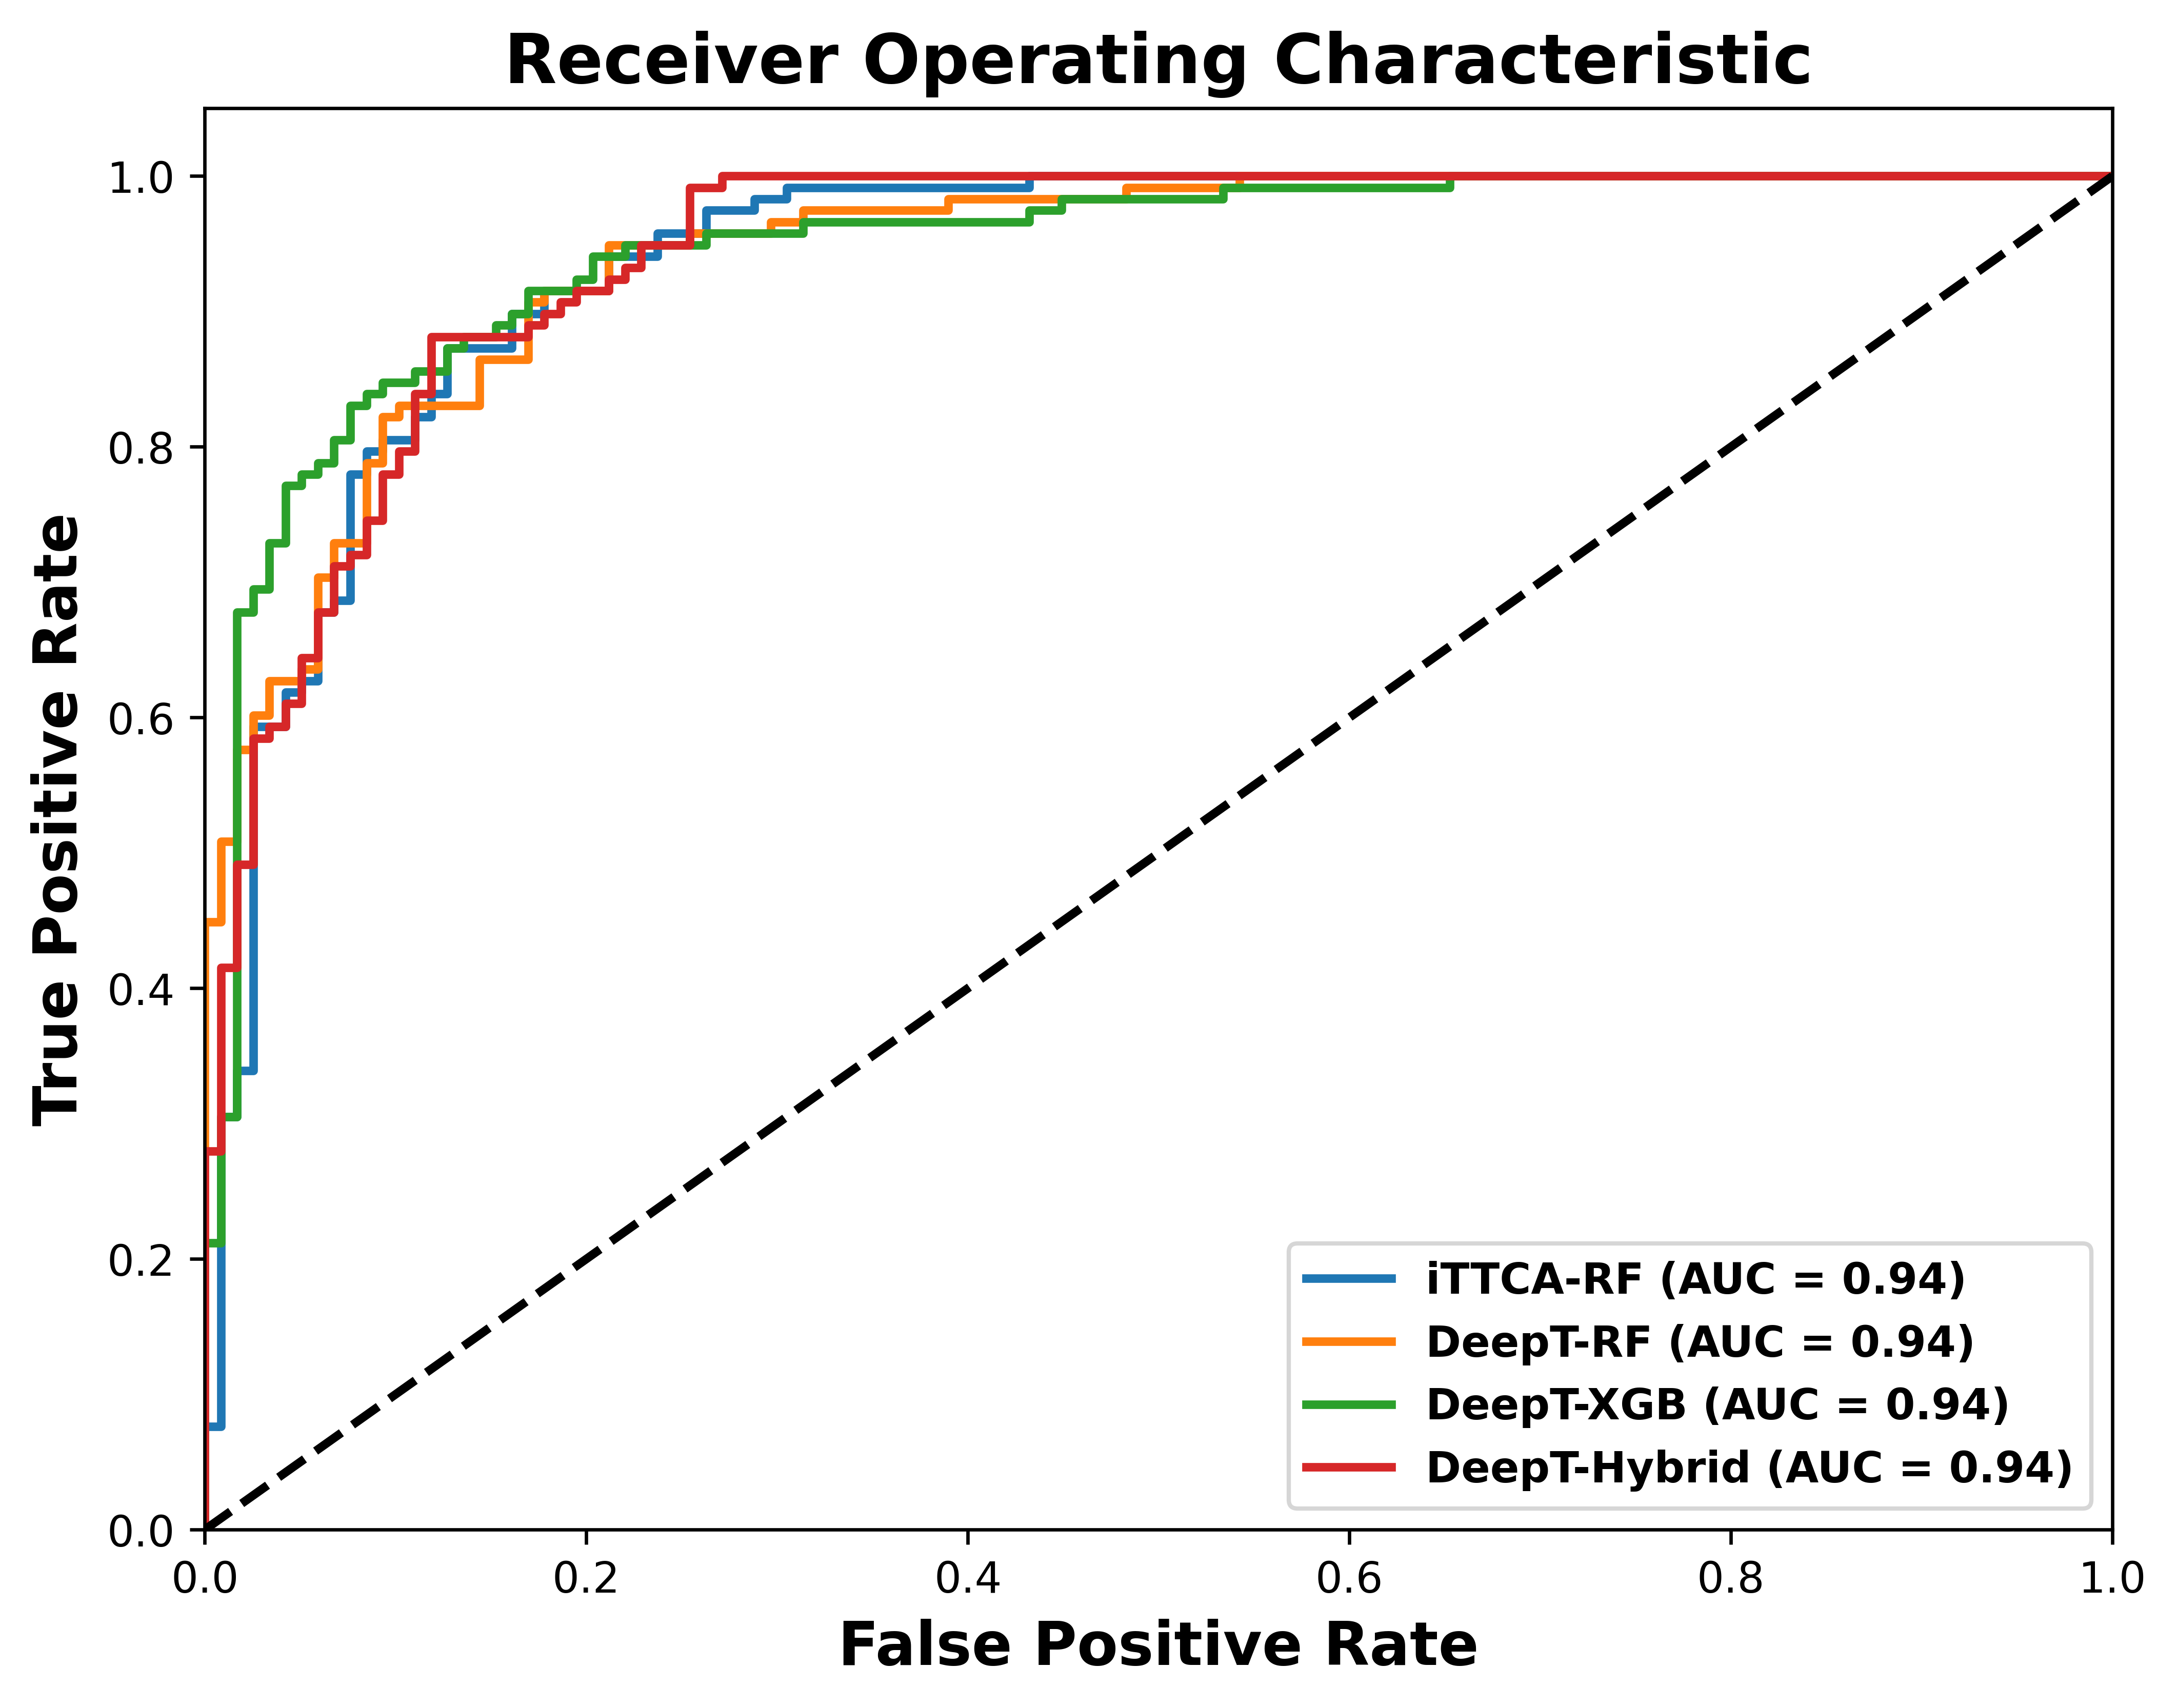

In [28]:
plt.figure(figsize=(8, 6), dpi=600)
#plt.plot(fpr1, tpr1, label='DeepT-CNN (AUC = %0.2f)' % auc1, linewidth=2)

plt.plot(fpr3, tpr3, label='iTTCA-RF (AUC = %0.2f)' % auc3, linewidth=2)
plt.plot(fpr5, tpr5, label='DeepT-RF (AUC = %0.2f)' % auc5, linewidth=2)
plt.plot(fpr8, tpr8, label='DeepT-XGB (AUC = %0.2f)' % auc8, linewidth=2)
plt.plot(fpr2, tpr2, label='DeepT-Hybrid (AUC = %0.2f)' % auc2, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Rastgele şansın eğrisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Receiver Operating Characteristic', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12, prop={'weight':'bold'})
plt.show()

